In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
import shutil
import os

import tensorflow as tf
import tensorflow.compat.v1 as tfv1

from sklearn.preprocessing import MinMaxScaler

from IPython.display import display

In [2]:
tfv1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
def read_data(dataset=None, filename=None):
    if dataset is not None:
        if not isinstance(dataset, pd.DataFrame):
            raise TypeError("Data must be an instance of pd.DataFrame")
            
    elif filename is not None:
        dataset = pd.read_csv(filename)
        
    else:
        raise ValueError("No data passed (dataset or filename can't be None)")
        
    dataset.columns = dataset.columns.str.lower()
    
    for column in dataset.columns:
        if column == "date" or dataset[column].dtype != "object": 
            try:
                dataset[column] = pd.to_numeric(dataset[column])

            except ValueError:
                dataset[column] = pd.to_datetime(dataset[column])

            except Exception:
                pass

    return dataset

def remove_dir(path_from_root):
    """remove directories"""
    shutil.rmtree(path_from_root, ignore_errors=True)
    
    
def make_dir_if_not_exists(path_from_root):
    '''creates directory if not exists'''
    
    if not os.path.exists(path_from_root):
        os.makedirs(path_from_root)

In [4]:
def handle_missing_values(data, threshold=0.7):
    #Dropping columns with missing value rate higher than threshold
    data = data[data.columns[data.isnull().mean() < threshold]]

    #Dropping rows with missing value rate higher than threshold
    data = data.loc[data.isnull().mean(axis=1) < threshold]
        
    # last observed carries forward
    data.fillna(method='ffill', inplace=True)

    # fill forward
    data.fillna(method='bfill', inplace=True)

    # filling missing values with medians of the columns
    data.fillna(data.median(), inplace=True)
    
    return data


def handle_outliers(data):
    #Dropping the outlier rows with Percentiles
    upper_lim = data.quantile(.95)
    lower_lim = data.quantile(.05)

    return data[(data < upper_lim) & (data > lower_lim)]


def log_transform(data):
    #Note that the values are different
    min_value = data.min()
    
    return np.log(data - min_value + 1), min_value
    

def inverse_log_transform(data, min_value):
    return (np.exp(data) + min_value) - 1


def scale_transform(data, scaler):    
    return scaler.transform(data), scaler


def inverse_scale_transform(data, scaler):
    return scaler.inverse_transform(data)


def get_numeric_columns(data):
    data = data[data.dtypes[data.dtypes != "object"].index]
    return data.dtypes[data.dtypes != "datetime64[ns]"].index

def feature_importance(data, target, threshold=0.3):
    numeric_feats = get_numeric_columns(data)
    
    imp_feats = list()
    cormat = data[numeric_feats].corr().fillna(0)
    
    """get target index for feature extraction"""
    target_idx = cormat.columns.get_loc(target)
    
    
    for feat in numeric_feats:
        try:
            if cormat[feat][target_idx] > threshold:
                imp_feats.append(feat)
                
        except Exception:
            pass
        
        
    return data[imp_feats]


def split(data, train_ratio):
    '''split into training and testing data sets'''

    # num of rows in data
    rows = data.shape[0]

    # training parameters
    split_point = int(train_ratio * rows)

    # split into two dataframes
    data_train = data.iloc[:split_point, :]
    data_test = data.iloc[split_point:, :]

    return data_train, data_test

def construct_label(data, target):
    '''appends the label column by shifting it down (1 day ahead)'''
    
    data['label'] = data[target]
    data['label'] = data['label'].shift(-1)
    
    return data.drop(data.index[len(data)-1])

def scale_transform(train_data, test_data):
    '''scales data using sklearn MinMaxScaler'''
    
    scaler = MinMaxScaler()
    scaler.fit(train_data)
    
    train_data_np = scaler.transform(train_data)
    test_data_np = scaler.transform(test_data)
    
    train_data = pd.DataFrame(train_data_np, index=train_data.index, columns=train_data.columns)
    test_data = pd.DataFrame(test_data_np, index=test_data.index, columns=test_data.columns)
    
    return train_data, test_data

In [5]:
def preprocess(target, output_path, input_path=None, train_ratio=0.7, validation_ratio=None, is_multi_variant=True, normalize=False, scale=True):
    dataset = read_data(filename=input_path)
    dataset = handle_missing_values(data=dataset)
    
    if is_multi_variant: # multivariate forecasting technique
        dataset = feature_importance(dataset, target)
        
    else: # univariate forecasting technique
        dataset = dataset[[target]]
    
    dataset = construct_label(data=dataset, target=target)
    
    # fill missing values
    dataset = handle_missing_values(data=dataset)
    
    # split into training and testing
    train_data, test_data = split(dataset, train_ratio)
    
    
    # normalize train and test dataset
    if normalize:
        pass
    
    # scale train and test dataset
    if scale:
        train_data, test_data = scale_transform(train_data, test_data)
        
    # make directory if not exist
    make_dir_if_not_exists(output_path)
        
    # validation data
    if validation_ratio:
        val_data, train_data = split(train_data, validation_ratio)
        val_data.to_csv(output_path + "val.csv", index=False)
    
    train_data.to_csv(output_path + "train.csv", index=False)
    test_data.to_csv(output_path + "test.csv", index=False)
    
    if not validation_ratio:
        print('saved csv files to ' + output_path + ' {train, test}/' + '.csv')
        return
        
    print('saved csv files to ' + output_path + ' {train, val, test}/' + '.csv')
    

preprocess(target="total", output_path="test_110/", input_path="supermarket_sales - Sheet1.csv", validation_ratio=None, is_multi_variant=False, scale=False)

saved csv files to test_110/ {train, test}/.csv


In [6]:
import time

In [7]:
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import Sequential


def create_model(X, p, n_neurons_1=32, n_neurons_2=16, n_neurons_3=8, n_target=1, X_train=None, y_train=None):
    # initializers
    sigma = 1
    weight_initializer = tfv1.variance_scaling_initializer(mode="fan_avg", distribution="uniform", scale=sigma)
    bias_initializer = tfv1.zeros_initializer()
    
    
    # Layer 1: Variable for hidden weights and biases
    W_hidden_1 = tfv1.Variable(weight_initializer([p, n_neurons_1]))
    bias_hidden_1 = tfv1.Variable(bias_initializer([n_neurons_1]))
    
    # Layer 2: Variables for hidden weights and biases
    W_hidden_2 = tfv1.Variable(weight_initializer([n_neurons_1, n_neurons_2]))
    bias_hidden_2 = tfv1.Variable(bias_initializer([n_neurons_2]))
    
    # Layer 3: Variables for hidden weights and biases
    W_hidden_3 = tfv1.Variable(weight_initializer([n_neurons_2, n_neurons_3]))
    bias_hidden_3 = tfv1.Variable(bias_initializer([n_neurons_3]))
    
    # Output layer: Variables for output weights and biases
    W_out = tfv1.Variable(weight_initializer([n_neurons_3, n_target]))
    bias_out = tfv1.Variable(bias_initializer([n_target]))
    
    # Hidden layer
    hidden_1 = tfv1.nn.relu(tfv1.add(tfv1.matmul(X, W_hidden_1), bias_hidden_1))
    hidden_2 = tfv1.nn.relu(tfv1.add(tfv1.matmul(hidden_1, W_hidden_2), bias_hidden_2))
    hidden_3 = tfv1.nn.relu(tfv1.add(tfv1.matmul(hidden_2, W_hidden_3), bias_hidden_3))

    # Output layer (must be transposed)
    out = tf.add(tf.matmul(hidden_3, W_out), bias_out, name='out')
    
    return out

INFO:tensorflow:Restoring parameters from test_110/

No checkpoint found


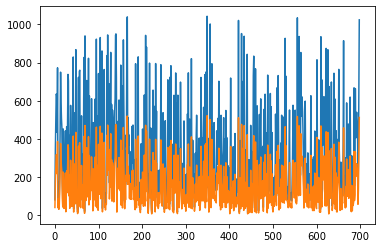


Final MSE validate: 95773.67
Final Relative error: 48.63%
Total training set count: 699
Total validate set count: 699

Saved model to  test_110/


,actual,pred
0,80.2200,356.193756
1,340.5255,54.587448
2,489.0480,222.074493
3,634.3785,317.637543
4,627.6165,411.146759
...,...,...
694,458.6925,322.799072
695,113.5680,298.106049
696,261.1980,76.044388
697,657.5310,171.033203


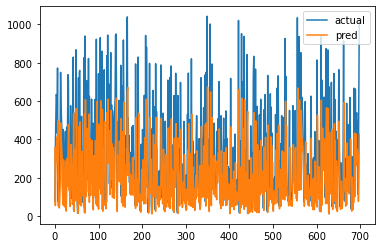


time elapsed: 6.21 seconds
training finished


In [9]:
def train(data_path, export_dir, epochs, batch_size, train_data=None, val_data=None):
    assert tf.io.gfile.exists(data_path), "data path does not exist"
        
    try:
        train_data = pd.read_csv(data_path + "train.csv")
        val_data = pd.read_csv(data_path + "val.csv")
        
    except FileNotFoundError:
        pass
    
    assert isinstance(train_data, pd.DataFrame), "No train data found"
    
#     remove_dir(export_dir)
    
    '''trains a neural network'''
    start_time = time.time()
    
    # build x and y    
    y_train = train_data[["label"]].transpose().values.flatten()
    train_data = train_data.drop(["label"], axis=1)
    X_train = train_data.values
    
    if isinstance(val_data, pd.DataFrame):
        y_val = val_data[["label"]].transpose().values.flatten()
        val_data = val_data.drop(["label"], axis=1)
        X_val = val_data.values
        
        
    p = X_train.shape[1]
    
    # Placeholder, None means we don't yet know the number of observations flowing through
    X = tfv1.placeholder(dtype=tf.float32, shape=[None, p], name='X')
    Y = tfv1.placeholder(dtype=tf.float32, shape=[None], name='Y')
    
    out = create_model(X, p, X_train=X_train, y_train=y_train.reshape(-1, 1))
    
    # cost function
    mse = tfv1.reduce_mean(tfv1.squared_difference(out, Y), name="mse")
    
    # optimizer
    opt = tfv1.train.AdamOptimizer().minimize(mse)
    
    # make session
    config = tfv1.ConfigProto(allow_soft_placement=True, gpu_options=tfv1.GPUOptions(per_process_gpu_memory_fraction=0.5, allow_growth=True))
    sess = tfv1.Session(config=config)
    
    restoremodel(sess, export_dir)
        
    # run initializer
    sess.run(tfv1.global_variables_initializer())
    
    if not isinstance(val_data, pd.DataFrame):
        X_val = X_train
        y_val = y_train
        
    # Setup plot
    plt.ion()
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    line1, = ax1.plot(y_val)
    line2, = ax1.plot(y_val * 0.5)
    plt.show()
    
    # Fit neural net
    mse_train = []
    mse_val = []
    
    # run
    for e in range(epochs):
        shuffle_indices = np.random.permutation(np.arange(len(y_train)))
        
        if X_train.shape[1] != 1:
            X_train = np.squeeze(X_train[shuffle_indices])
            y_train = np.squeeze(y_train[shuffle_indices])
        
        # Minibatch training
        for i in range(0, len(y_train) // batch_size):
            start = i * batch_size
            batch_x = X_train[start: start + batch_size]
            batch_y = y_train[start: start + batch_size]
                        
            # run optimizer with batch
            sess.run(opt, feed_dict={X: batch_x, Y: batch_y})
            
        # MSE train and validate
        mse_train.append(sess.run(mse, feed_dict={X: X_train, Y: y_train}))
        
        if isinstance(val_data, pd.DataFrame):
            mse_val.append(sess.run(mse, feed_dict={X: X_val, Y: y_val}))
        
#         print('Epoch ' + str(e))
#         print('MSE Train: ', mse_train[-1])
#         print('MSE Validate: ', mse_val[-1])
        
#         # prediction
#         pred = sess.run(out, feed_dict={X: X_train, Y: y_train})
#         rel_error = abs(np.mean(((pred - y_val) / y_val)))
#         print("Relative error: {:.2f}\n".format(rel_error))
    
    # Print final MSE after Training
    pred_final = sess.run(out, feed_dict={X: X_val})
    rel_error = abs(np.mean(((pred_final - y_val) / y_val)))
    mse_final = sess.run(mse, feed_dict={X: X_val, Y: y_val})
    
    print('\nFinal MSE validate: ' + str(mse_final))
    print('Final Relative error: ' + str("{:.2%}".format(rel_error)))
    print('Total training set count: ' + str(len(y_train)))
    print('Total validate set count: ' + str(len(y_val)))
    
    
    savemodel(sess, export_dir)
    elapsed = time.time() - start_time
    
    y_val = y_val.reshape(-1, 1)
    d_frame = pd.DataFrame(data=np.concatenate([y_val, pred_final], axis=1), columns=["actual", "pred"])
    
    display(d_frame)
    d_frame.plot()
    plt.show()
    
    print('\ntime elapsed: ' + str(round(elapsed, 2)) + " seconds")
    
    print('training finished')
    sess.close()
        
    
def savemodel(sess, export_dir):
    saver = tfv1.train.Saver()
    saver.save(sess, export_dir)
    
    print("\nSaved model to ", export_dir)
    

def restoremodel(sess, export_dir):
    try:
        saver = tfv1.train.Saver()
        saver.restore(sess, export_dir)
        
        print("\nRestore model from ", export_dir)
        
    except:
        print("\nNo checkpoint found")
    
    
train(data_path="test_110/", export_dir="test_110/", epochs=2, batch_size=1)